In [1]:
import numpy as np
npl, npr = np.linalg, np.random

import matplotlib.pyplot as plt

from scipy.signal import correlate, welch, csd, dlti, dlsim, lti, lsim
from scipy.fft import fft, fftfreq

[(-5.0, 5.0), Text(0, 0.5, 'White noise')]

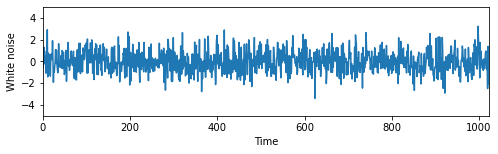

In [45]:
# --> Generate a random white noise sequence.
n = 2**18
k = np.arange(n)
x = npr.randn(n)
#x = npr.laplace(size=n)
#print(x.var())

# --> Plot the sequence.
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ax.plot(k, x)
ax.set(xlim=(0, 1024), xlabel="Time")
ax.set(ylim=(-5, 5), ylabel="White noise")

[(0.0, 0.5), Text(0, 0.5, 'PDF')]

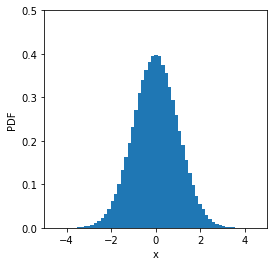

In [46]:
# -->
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.hist(x, bins=64, density=True)
ax.set(xlim=(-5, 5), xlabel="x")
ax.set(ylim=(0, 0.5), ylabel="PDF")

[(-0.1, 1.1), Text(0, 0.5, 'Rxx(τ)')]

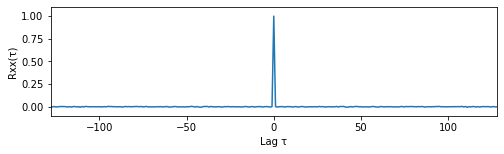

In [47]:
# --> Compute the auto-correlation function using SciPy.
Rxx = correlate(x, x) / np.linalg.norm(x)**2
k = np.arange(len(Rxx)) - len(Rxx)//2

# --> Plot the auto-correlation function.
fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ax.plot(k, Rxx)
ax.set(xlim=(-128, 128), xlabel="Lag τ")
ax.set(ylim=(-0.1, 1.1), ylabel="Rxx(τ)")

[(0.0, 5.0), Text(0, 0.5, 'PSD')]

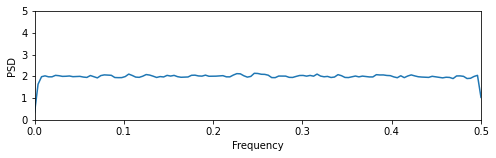

In [48]:
freq, Sxx = welch(x)

fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.plot(freq, Sxx)
ax.set(xlim=(freq.min(), freq.max()), xlabel="Frequency")
ax.set(ylim=(0, 5), ylabel="PSD")

In [49]:
def orstein_uhlenbeck(n, α=0.95, σ=0.5):
    y = np.zeros(2*n)
    #x = npr.randn(2*n)
    x = npr.laplace(size=2*n)
    for i in range(1, 2*n):
        y[i] = α*y[i-1] + σ*x[i]
    return y[n:], x[n:]

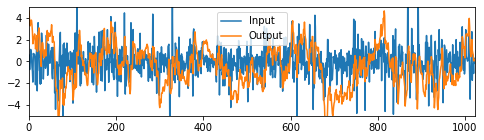

In [50]:
y, x = orstein_uhlenbeck(n)

fig, ax = plt.subplots(1, 1, figsize=(8, 2))

ax.plot(x, label="Input")
ax.plot(y, label="Output")
ax.set(xlim=(0, 1024), ylim=(-5, 5))
ax.legend(loc=0)

[(0.0, 0.5), Text(0, 0.5, 'PDF')]

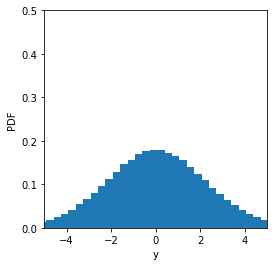

In [51]:
# -->
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.hist(y, bins=64, density=True)
ax.set(xlim=(-5, 5), xlabel="y")
ax.set(ylim=(0, 0.5), ylabel="PDF")

[(-0.1, 1.1), Text(0, 0.5, 'Ryy(τ)')]

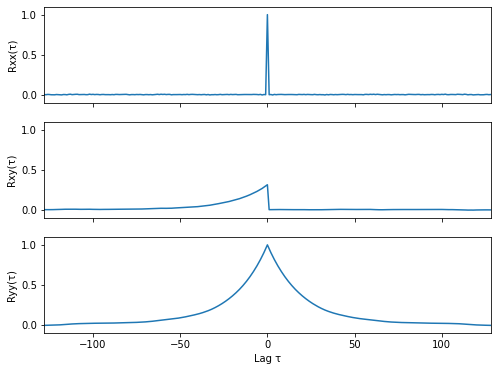

In [52]:
# --> Compute the auto-correlation function using SciPy.
Ryy = correlate(y, y) / np.linalg.norm(y)**2
Rxx = correlate(x, x) / np.linalg.norm(x)**2
Rxy = correlate(x, y) / (np.linalg.norm(y) * np.linalg.norm(x))

k = np.arange(len(Ryy)) - len(Ryy)//2

# --> Plot the auto-correlation function.
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)

ax[0].plot(k, Rxx)
ax[1].plot(k, Rxy)
ax[2].plot(k, Ryy)

ax[-1].set(xlim=(-128, 128), xlabel="Lag τ")
ax[0].set(ylim=(-0.1, 1.1), ylabel="Rxx(τ)")
ax[1].set(ylim=(-0.1, 1.1), ylabel="Rxy(τ)")
ax[2].set(ylim=(-0.1, 1.1), ylabel="Ryy(τ)")

[(0.0, 0.5), Text(0.5, 0, 'Frequency')]

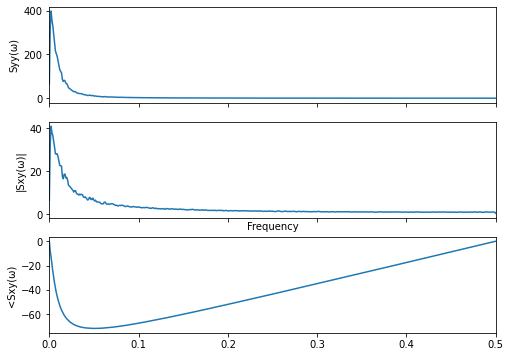

In [54]:
freq, Syy = welch(y, nperseg=1024)
_, Sxy = csd(x, y, nperseg=1024)

fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax[0].plot(freq, Syy)
ax[0].set(ylabel="Syy(ω)")

ax[1].plot(freq, np.abs(Sxy))
ax[1].set(ylabel="|Sxy(ω)|")

ax[2].plot(freq, np.angle(Sxy, deg=True))
ax[2].set(ylabel="<Sxy(ω)")

ax[1].set(xlim=(freq.min(), freq.max()), xlabel="Frequency")

In [55]:
# --> Construct the matrices.
def build_system(ξ=0.1):
    # --> Dynamics matrix.
    A = np.array([
        [0.0, 1.0],
        [-1.0, -2*ξ]])
    
    # --> Input-to-state matrix.
    B = np.array([[0.0], [1.0]])
    
    # --> State-to-output matrix.
    C = np.array([[1.0, 0.0]])
    
    # --> Input-to-output matrix.
    D = np.array([[0.0]])
    
    return lti(A, B, C, D)

# --> Instantiate the system.
sys = build_system()

# --> Generate impulse response data.
t_fir, fir = sys.impulse(T=np.linspace(0, 400, 4001))
Δt = t_fir[1] - t_fir[0] # Sampling time.

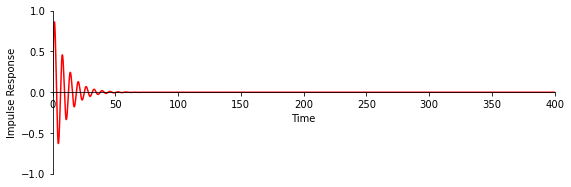

In [56]:
# --> Plot the Impulse Response.
fig, ax = plt.subplots(1, 1, figsize=(9, 3))

ax.plot(t_fir, fir, c="r")

ax.set(xlim=(0, t_fir.max()), ylim=(-1, 1))
ax.set(xlabel="Time", ylabel="Impulse Response")

ax.locator_params(axis="y", nbins=5)

ax.spines["bottom"].set_position("center")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [65]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

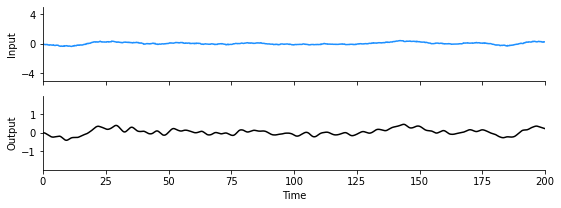

In [71]:
# --> Pseudo-random input.
#u = npr.randn(2*n)
u = npr.laplace(size=2*n)
u = moving_average(u, n=128)


# --> Excite the system.
t, y, _ = lsim(sys, U=u, T=np.arange(len(u))*Δt)

# --> Plot the input/output data.
fig, axes = plt.subplots(2, 1, figsize=(9, 3), sharex=True)

axes[0].plot(t, u, c="dodgerblue")
axes[0].set(xlim=(t.min(), t.max()), ylim=(-5, 5))
axes[0].set(yticks=[-4, 0, 4], ylabel="Input")
axes[0].spines["top"].set_visible(False)
axes[0].spines["right"].set_visible(False)

axes[1].plot(t, y, c="k")
axes[1].set(xlim=(0, 200), ylim=(-2, 2))
axes[1].set(yticks=[-1, 0, 1], ylabel="Output", xlabel="Time")
axes[1].spines["top"].set_visible(False)
axes[1].spines["right"].set_visible(False)

(array([   506.,   4033.,  24621.,  85652., 160757., 151045.,  76980.,
         18259.,   2140.,    168.]),
 array([-0.50909302, -0.40537108, -0.30164914, -0.1979272 , -0.09420527,
         0.00951667,  0.11323861,  0.21696054,  0.32068248,  0.42440442,
         0.52812635]),
 <BarContainer object of 10 artists>)

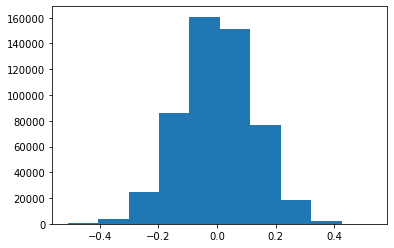

In [72]:
plt.hist(u)

[(-1.1, 1.1), Text(0, 0.5, 'Ryy(τ)')]

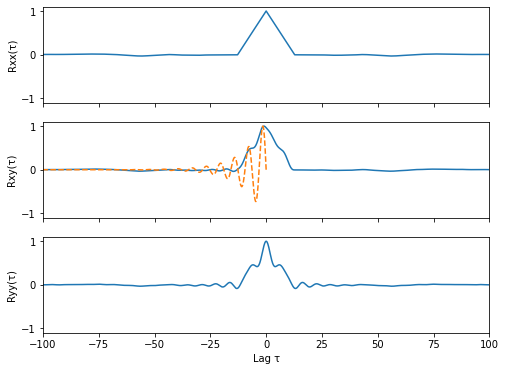

In [73]:
# --> Compute the auto-correlation function using SciPy.
Ryy = correlate(y, y) / np.linalg.norm(y)**2
Rxx = correlate(u, u) / np.linalg.norm(u)**2
Rxy = correlate(u, y) / (np.linalg.norm(y) * np.linalg.norm(u))

k = Δt * (np.arange(len(Ryy)) - len(Ryy)//2)

# --> Plot the auto-correlation function.
fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)

ax[0].plot(k, Rxx)
ax[1].plot(k, Rxy/Rxy.max())
ax[1].plot(-t_fir, fir/fir.max(), '--')
ax[2].plot(k, Ryy)

ax[-1].set(xlim=(-100, 100), xlabel="Lag τ")
ax[0].set(ylim=(-1.1, 1.1), ylabel="Rxx(τ)")
ax[1].set(ylim=(-1.1, 1.1), ylabel="Rxy(τ)")
ax[2].set(ylim=(-1.1, 1.1), ylabel="Ryy(τ)")

[(0.001, 31.41592653589793), Text(0.5, 0, 'Frequency')]

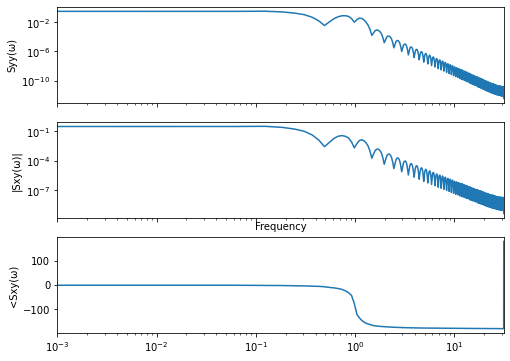

In [74]:
freq, Sxx = welch(x, nperseg=1024, fs=1/Δt)
freq, Syy = welch(y, nperseg=1024, fs=1/Δt)
_, Sxy = csd(u, y, nperseg=1024, fs=1/Δt)

fig, ax = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
ax[0].loglog(2*np.pi * freq, Syy)
ax[0].set(ylabel="Syy(ω)")

ax[1].loglog(2*np.pi * freq, np.abs(Sxy))
ax[1].set(ylabel="|Sxy(ω)|")

ax[2].plot(2*np.pi * freq, np.angle(Sxy, deg=True))
ax[2].set(ylabel="<Sxy(ω)")

ax[1].set(xlim=(2*np.pi * freq.min()+1e-3, 2*np.pi * freq.max()), xlabel="Frequency")